# COSC 6373 - HW6-ICA - Minh Nguyen #2069407

In [ ]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# The dimensions of our input image
img_width = 180
img_height = 180

# See `model.summary()` for list of layer names, if you want to change this.

# Target layers to visualize the filters
layers = ["conv1_conv", "conv2_block1_1_conv", "conv3_block1_1_conv", "conv4_block1_1_conv", "conv5_block1_1_conv"]

In [25]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)

# model.summary()

In [26]:
# Build a feature extraction model
def build_feature_extractor(layer_name):
    return keras.Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)

In [27]:
# Function to compute loss (activation of a specific filter in a layer)
def compute_loss(input_image, feature_extractor, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

# Gradient ascent step to maximize filter activation
@tf.function
def gradient_ascent_step(img, feature_extractor, filter_index, learning_rate=10.0):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, feature_extractor, filter_index)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [28]:
# Function to initialize a random gray image
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25

# Function to preprocess image for display
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.15
    
    # Center crop
    img = img[25:-25, 25:-25, :]
    
    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

# Function to visualize the first 8 filters of a layer
def visualize_filters(layer_name, num_filters=8):
    feature_extractor = build_feature_extractor(layer_name)
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 5))
    for i in range(num_filters):
        img = initialize_image()
        for _ in range(30):  # 30 iterations of gradient ascent
            _, img = gradient_ascent_step(img, feature_extractor, i)
        img = deprocess_image(img[0].numpy())
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Filter {i}")
    plt.show()

Visualizing filters in layer: conv1_conv


/Users/ndminh/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_760']. Received: the structure of inputs=*
  warnings.warn(


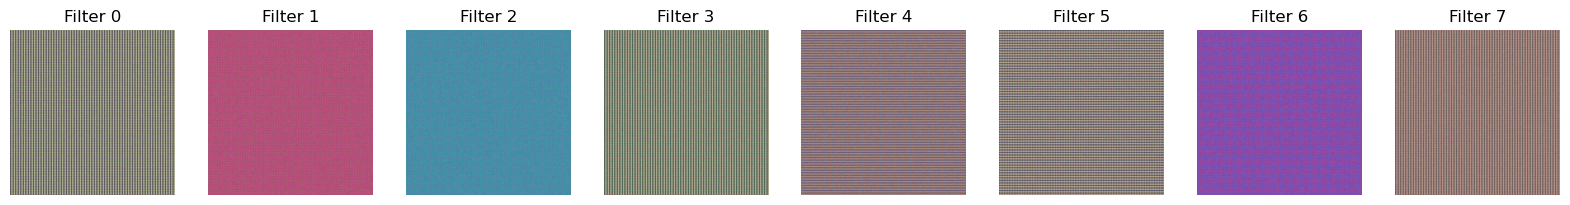

Visualizing filters in layer: conv2_block1_1_conv


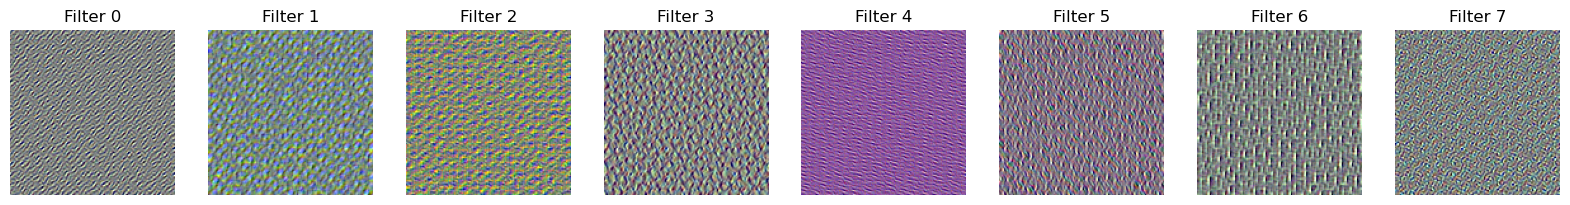

Visualizing filters in layer: conv3_block1_1_conv


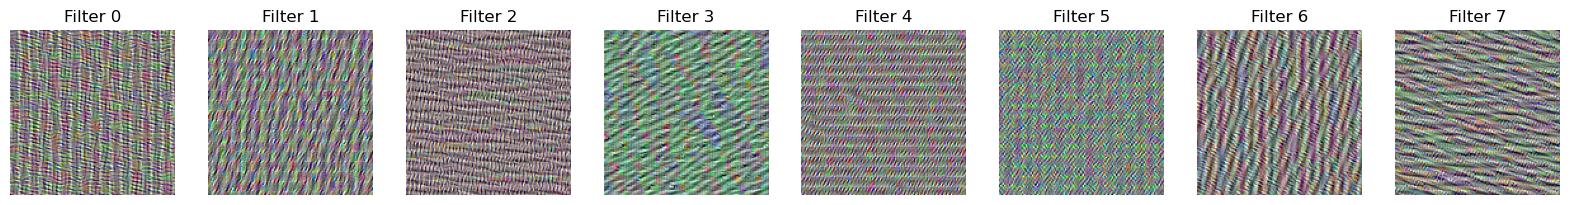

Visualizing filters in layer: conv4_block1_1_conv


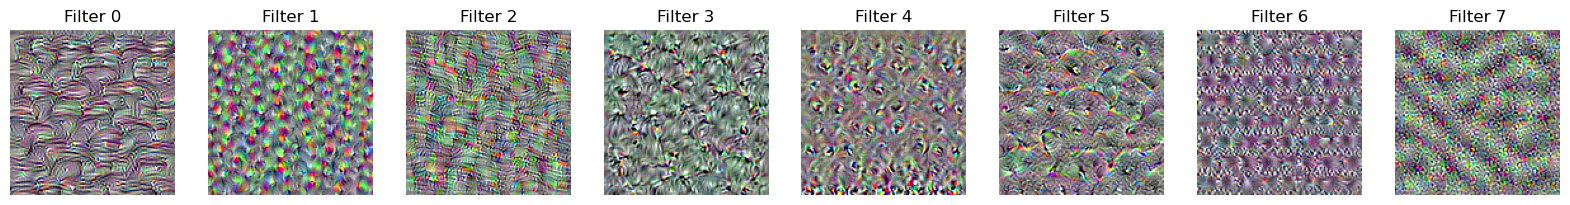

Visualizing filters in layer: conv5_block1_1_conv


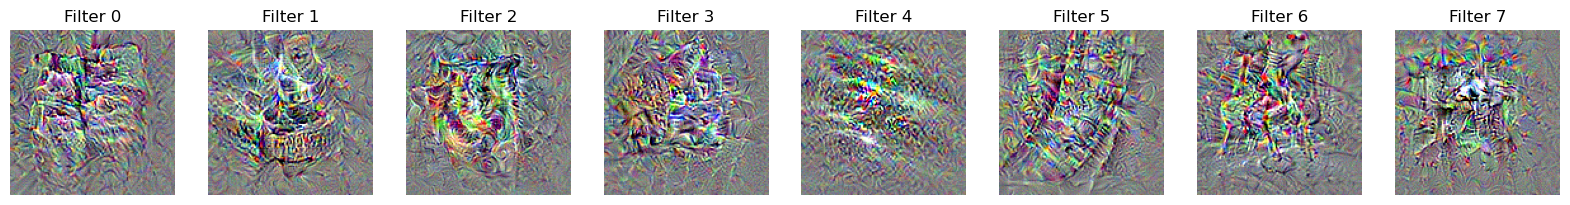

In [29]:
# Visualizing the first 8 filters in each specified layer
for layer in layers:
    print(f"Visualizing filters in layer: {layer}")
    visualize_filters(layer)

### Observations from Filter Visualizations
1. Layer `conv1_covn` can capture the simple horizontal and vertical edges of the image.
2. Layer `conv2_block1_1_conv` can capture the basic shapes and textures of the image.
3. Layer `conv3_block1_1_conv` starts to capture more complex shapes and textures of the image such as curves, corners, and textures.
4. Layer `conv4_block1_1_conv` captures even more complex shapes and textures of the image such as patterns, curves, textures, and more complex shapes. It also starts recognizing object parts in the image.
5. Layer `conv5_block1_1_conv` captures abstract features of the image such as object parts, textures, and patterns. It starts resembling complex structures of the image.

### Information that each filter learns
- Early layers like `conv1_conv` and `conv2_block1_1_conv` learn simple, basic features like edges, corners, and textures. They are able to detect simple patterns and details like brightness and contrast.
- Middle layers like `conv3_block1_1_conv` and `conv_4_block1_1_conv` learn more complex features and start recognizing patterns in textures like repeated stripes, grids, curves, etc.
- Deeper layers like `conv5_block1_1_conv` learns high-level, abstract features like object parts, textures, and patterns. It less focuses on pixel-level details and more on the semantic meaning of the image.